<a href="https://colab.research.google.com/github/DestonSJU/GenAI/blob/main/HW4/Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

//*** Deston Willis

//*** Generative AI

//*** 11/4/24

//*** Homework 4: The purpose of this assignment is to create a GAN model and use it to generate images of bedrooms and compare those images to the training bedroom images.

1. First I download the data and import it into google colab. Next I take subset of 5000 random images and put them into their own folder to be used as the data for the GAN. I then preprocess the images and display a few of them. The images are 64x64 and are rgb.

In [ ]:
#Initial Imports
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
    utils,
)

In [ ]:
#Initalize parameters for model
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 32
Z_DIM = 100


EPOCHS = 100

LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

In [ ]:
#Mounts google drive to download dataset from google drive
from google.colab import drive
import zipfile
import os

# First, mount Google Drive to access the file
drive.mount('/content/drive')

# Paths
zip_file_path = '/content/drive/My Drive/Colab Notebooks/bedrooms.zip'
extract_to = '/content/'

# Extract the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Verify the extracted contents
os.listdir(extract_to)

# List the contents of the 'content' directory
os.listdir('/content')

Mounted at /content/drive


['.config', 'data0', 'sample', 'drive', 'sample_data']

In [ ]:
#Creates a list of all images
import glob
#Change working directory
os.chdir("/content/")
all_images = glob.glob("**/*.jpg", recursive=True)

In [ ]:
#Randomly selects 20000 images and creates a subset with them
import random
images_subset = random.sample(all_images, 20000)
#Makes new directory
os.mkdir("/content/images")

In [ ]:
#Copys all images into new directory
import shutil
for x in images_subset:
  shutil.copy2(x, '/content/images') # target filename is /dst/dir/file.ext

In [ ]:
#Images to be preprocessed
train_data =  tf.keras.preprocessing.image_dataset_from_directory(
    "images/",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 19668 files belonging to 1 classes.


In [ ]:
#Function to preprocess images
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img

#Use preprocess function
train = train_data.map(lambda x: preprocess(x))

In [ ]:
#Defines functions from utils.py (Couldn't import/install utils.py so I took the functions I need from it and defined them here)
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [ ]:
#Sample of th the images
train_sample = sample_batch(train)

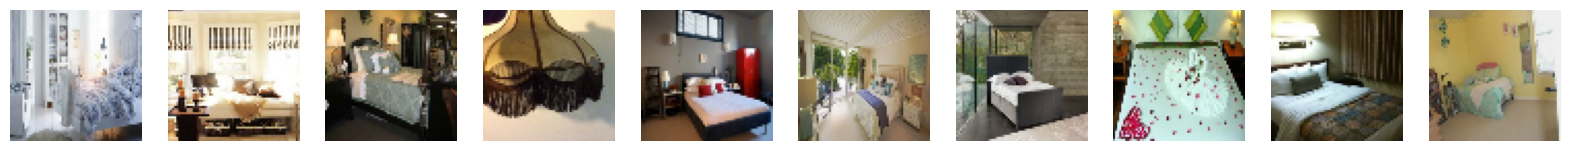

In [ ]:
#Display 10 images
display(train_sample)

2. I defined two functions: make_generator_model and make_discriminator_model. These function create and return a generator and discriminator respectively. For the discriminator I have the following layers: Input, Conv2D, LeakyReLU, Dropout, 3 sets of the folowing layers: Conv2D, BatchNormalization, LeakyReLU, Dropout, then a final Conv2D and a Flatten layer. For the generator I have the following layers: Input, Reshape, 4 sets of Conv2DTranspose, BarchNormalization, and LeakyReLU layers, and finally a final Conv2DTranspose layer. These functions are used to create the generator and discriminator that are used in the GAN.

In [ ]:
#Function that creates and returns generator
def make_generator_model():
    model = tf.keras.Sequential([
    layers.Input(shape=(Z_DIM,)),
    layers.Reshape((1, 1, Z_DIM)),
    layers.Conv2DTranspose( 512, kernel_size=4, strides=1, padding="valid", use_bias=False),
    layers.BatchNormalization(momentum=0.9),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias=False),
    layers.BatchNormalization(momentum=0.9),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False),
    layers.BatchNormalization(momentum=0.9),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False),
    layers.BatchNormalization(momentum=0.9),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(CHANNELS, kernel_size=4, strides=2, padding="same", use_bias=False, activation="tanh")
    ])
    model.summary()
    return model

#Function that creates and returns discriminator
def make_discriminator_model():
    model = tf.keras.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.3),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False),
    layers.BatchNormalization(momentum=0.9),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.3),
    layers.Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False),
    layers.BatchNormalization(momentum=0.9),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.3),
    layers.Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False),
    layers.BatchNormalization(momentum=0.9),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.3),
    layers.Conv2D(1, kernel_size=4, strides=1, padding="valid", use_bias=False, activation="sigmoid"),
    layers.Flatten()
    ])
    model.summary()
    return model

In [ ]:
#Create generator and discriminator
generator = make_generator_model()
discriminator = make_discriminator_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         819200    
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 4, 4, 512)         2048      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 256)         2097152   
 Transpose)                                                      
                                                        

3 and 4. Next I define a class that has various functions for the GAN model. I then create and comile a GAN model. I then defined the ImageGenerator class. I then trained the GAN. I started by training with 5000 images for 50 epochs, a batch size of 256, noise_dim of 100, and number of examples of 16. These are the stats of the model: d_loss: 0.2252 - d_real_acc: 0.8407 - d_fake_acc: 0.8795 - g_loss: 3.9639 - g_acc: 0.1205. The images that were generated with this model were very bad and didn't resemble a bedroom much at all.

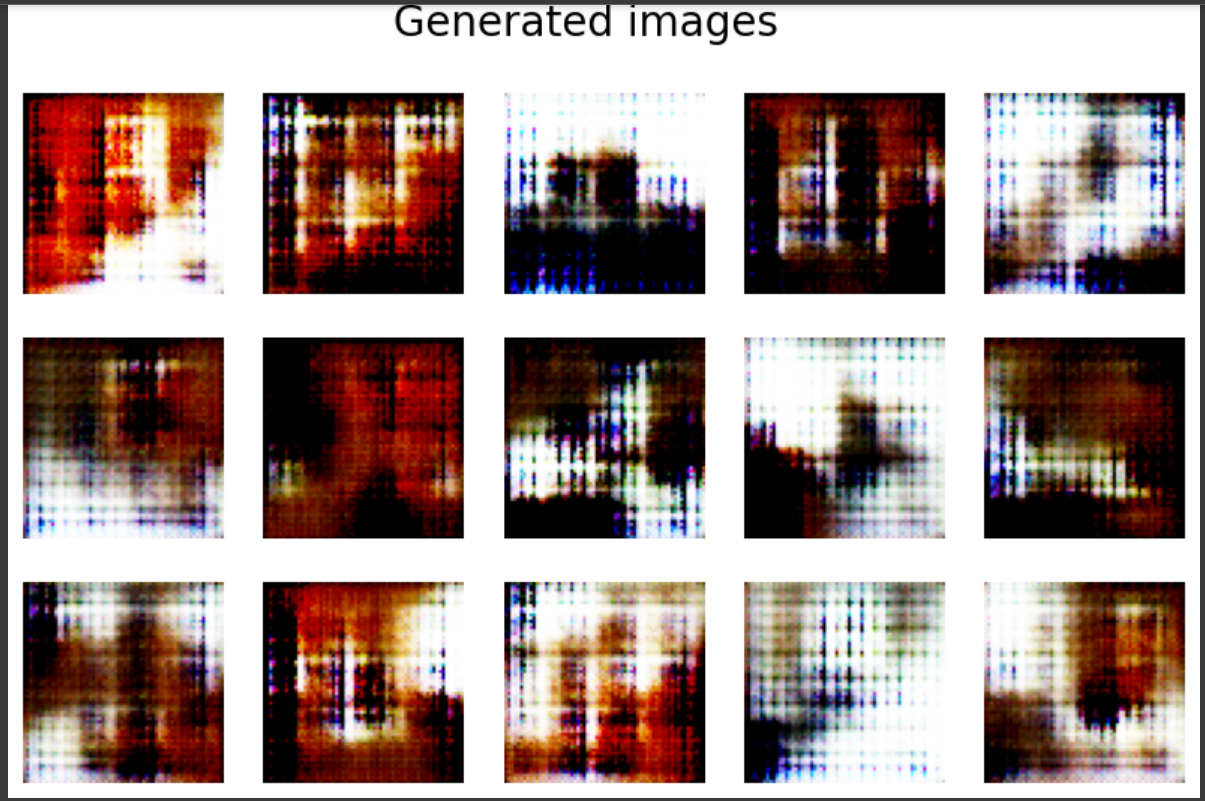



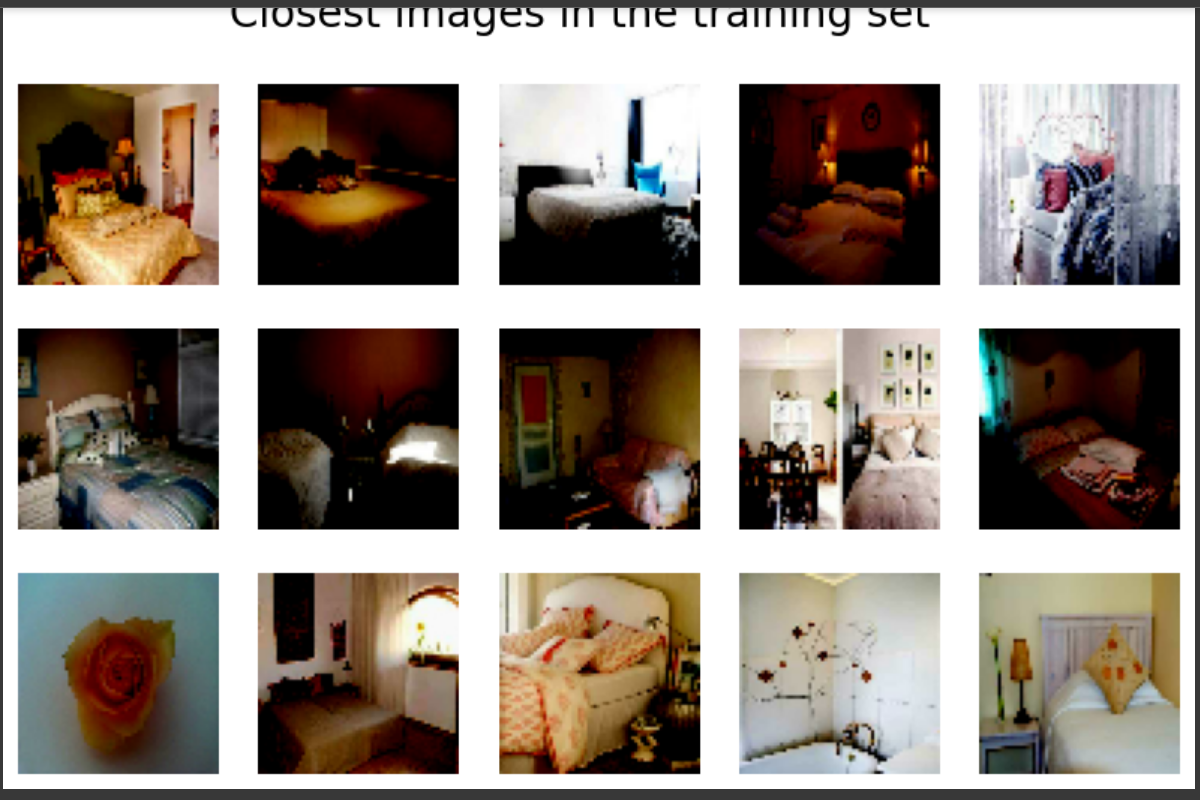

I then changed the model by increasing the number of images to 10000, increasing the epochs to 100, and decreasing the batch size to 64. After training the model these are the stats: d_loss: 7.6254 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.5000 - g_loss: 0.0000e+00 - g_acc: 1.0000. Overall these stats are better than the previous models. As well, the images that were generated with this model were significantly better than the ones from the previous model. They were still very blurry and sludgy and most of them didn't look much like a bedroom but there were a few that weren't terrible and started to resemble a bedroom.

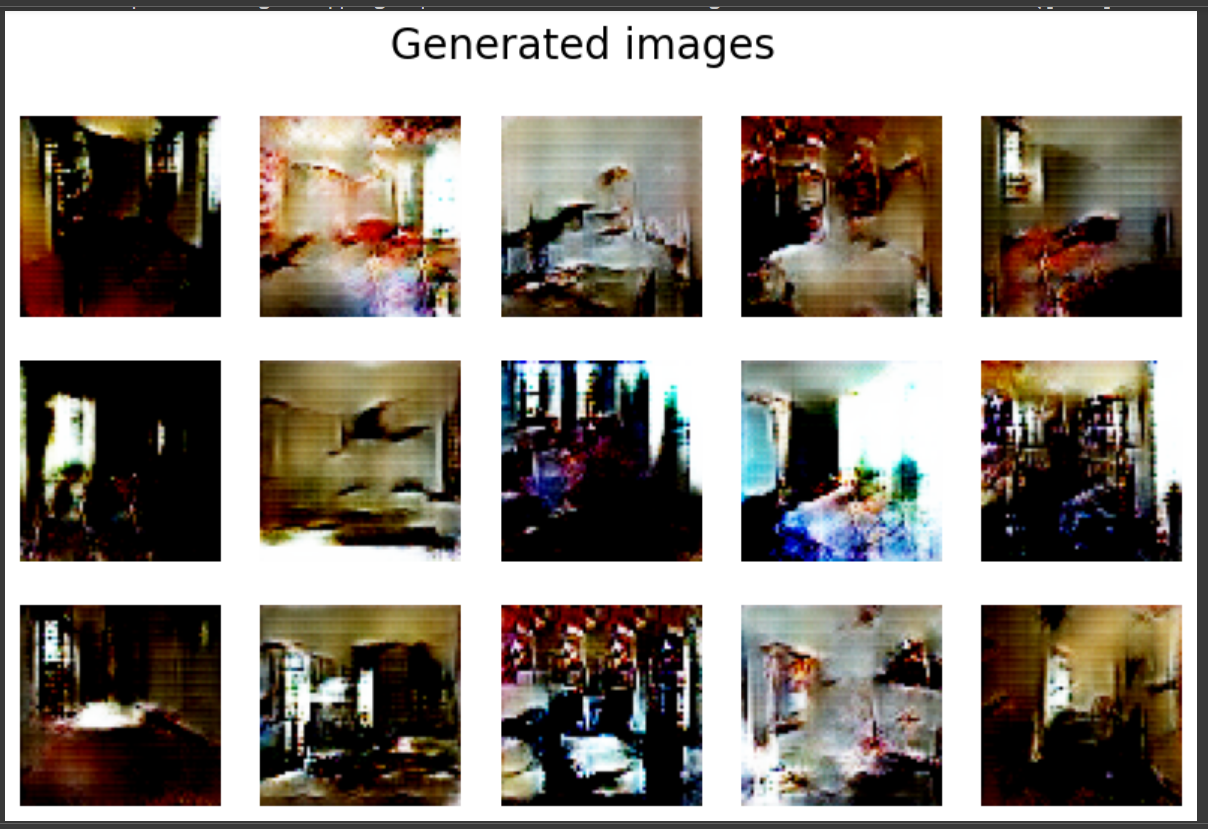

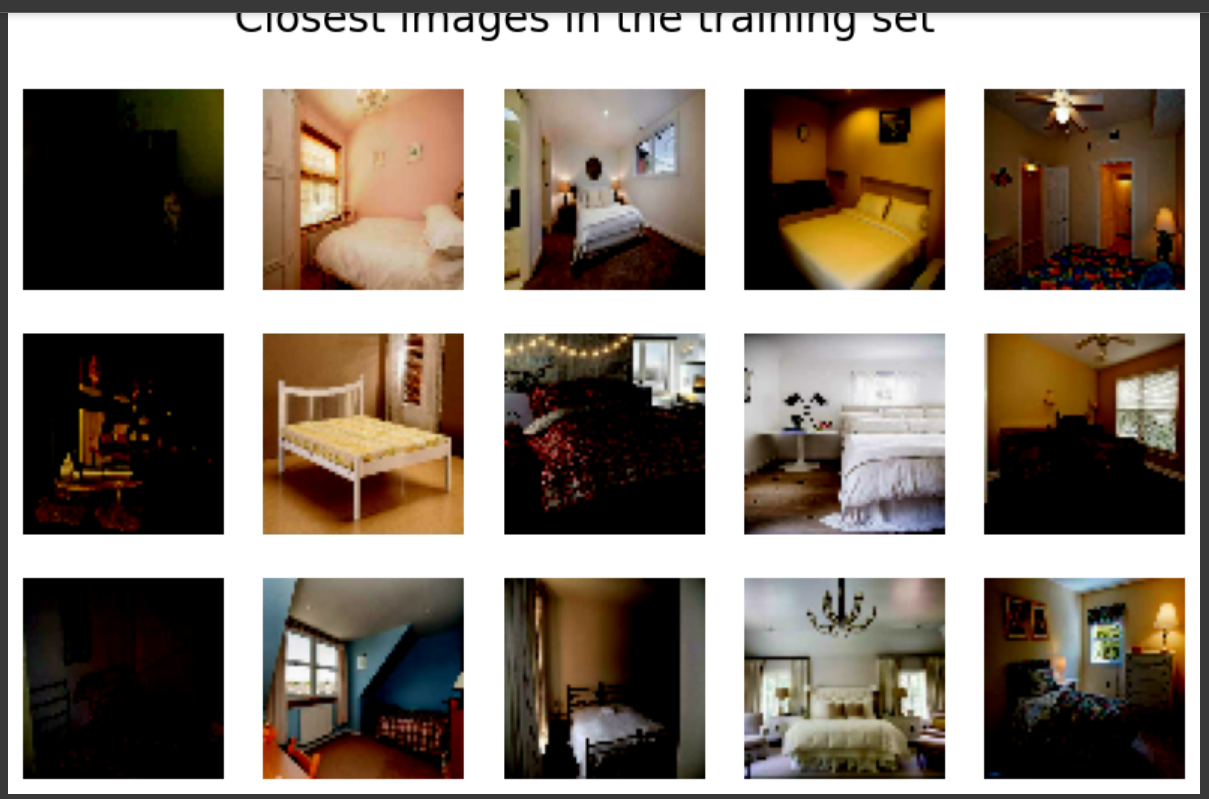

I changed the model one more time by increasing the number of images to 20000 and decreasing the batch size to 32. After training the model these are the stats: d_loss: 7.6226 - d_real_acc: 1.0000 - d_fake_acc: 0.0000e+00 - d_acc: 0.5000 - g_loss: 0.0000e+00 - g_acc: 1.0000. The stats of this model compared to this one are almost exactly the same. However, these images look better than the previous two models. The still are the best and some of them don't look like bedrooms but there are some that at least somewhat resemble a bedroom.

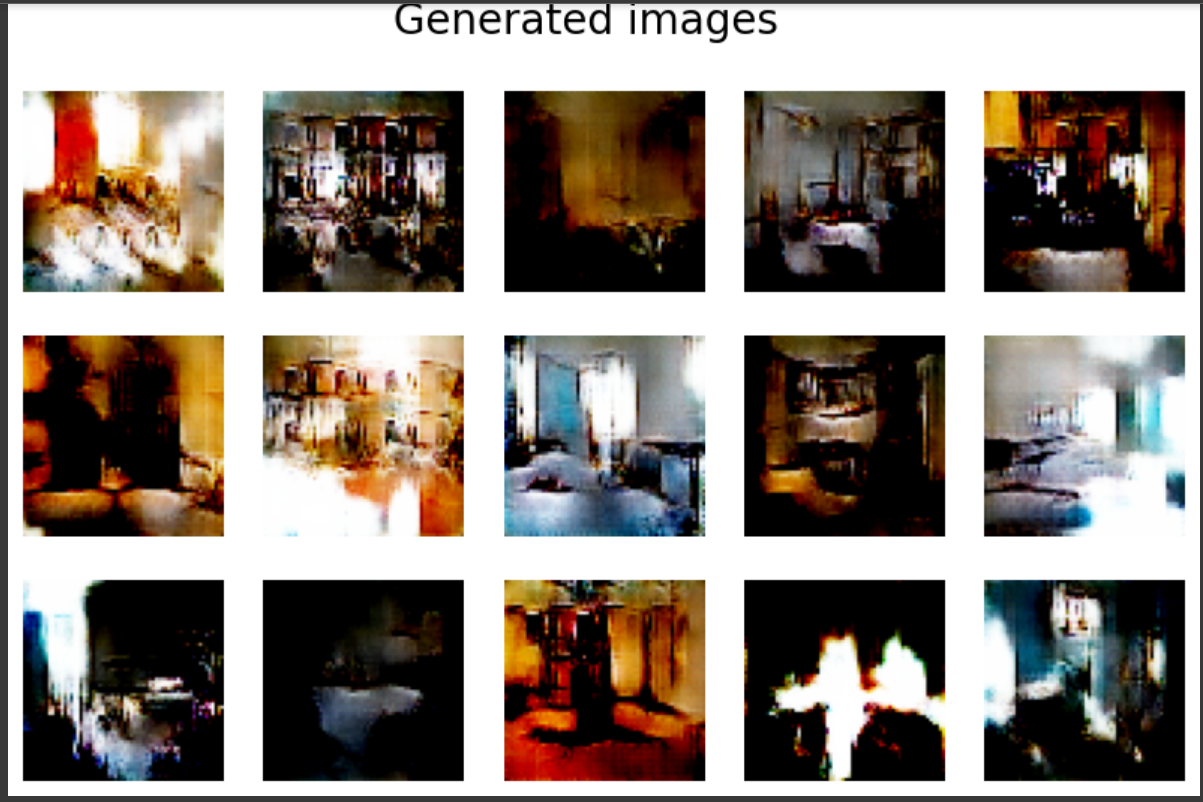

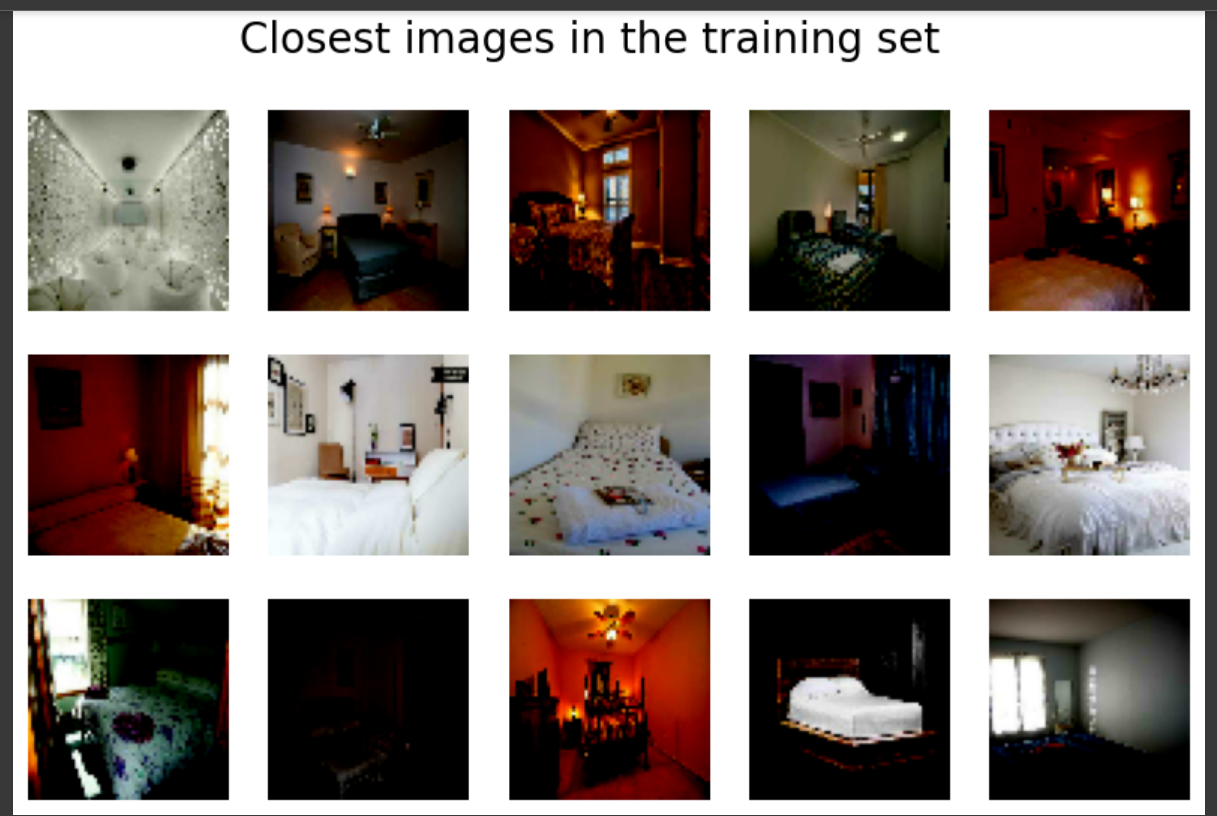

In [ ]:
#Class with functions for GAN model
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [ ]:
# Creates a GAN model
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [ ]:
#Compiles the GAN model
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [ ]:
#Class to generate images
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()

In [ ]:
#Trains the model
dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        ImageGenerator(num_img=16, latent_dim=Z_DIM),
    ],
)

Epoch 1/100
615/615 [==============================] - 92s 145ms/step - d_loss: 0.1782 - d_real_acc: 0.8489 - d_fake_acc: 0.8781 - d_acc: 0.8635 - g_loss: 3.4301 - g_acc: 0.1219
Epoch 2/100
615/615 [==============================] - 90s 146ms/step - d_loss: 0.2182 - d_real_acc: 0.8399 - d_fake_acc: 0.8539 - d_acc: 0.8469 - g_loss: 3.0669 - g_acc: 0.1461
Epoch 3/100
615/615 [==============================] - 90s 147ms/step - d_loss: 0.1230 - d_real_acc: 0.8750 - d_fake_acc: 0.8790 - d_acc: 0.8770 - g_loss: 3.7611 - g_acc: 0.1210
Epoch 4/100
615/615 [==============================] - 89s 145ms/step - d_loss: 0.0324 - d_real_acc: 0.8995 - d_fake_acc: 0.9054 - d_acc: 0.9024 - g_loss: 4.5229 - g_acc: 0.0946
Epoch 5/100
615/615 [==============================] - 88s 143ms/step - d_loss: -0.0328 - d_real_acc: 0.9127 - d_fake_acc: 0.9170 - d_acc: 0.9148 - g_loss: 5.4563 - g_acc: 0.0830
Epoch 6/100
615/615 [==============================] - 87s 141ms/step - d_loss: -0.0624 - d_real_acc: 0.9166 

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [ ]:
# Decode the sampled points
reconstructions = generator.predict(z_sample)

1/1 [==============================] - 0s 181ms/step


In [ ]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

<Figure size 1800x500 with 0 Axes>

In [ ]:
# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [ ]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [ ]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

1/1 [==============================] - 0s 37ms/step


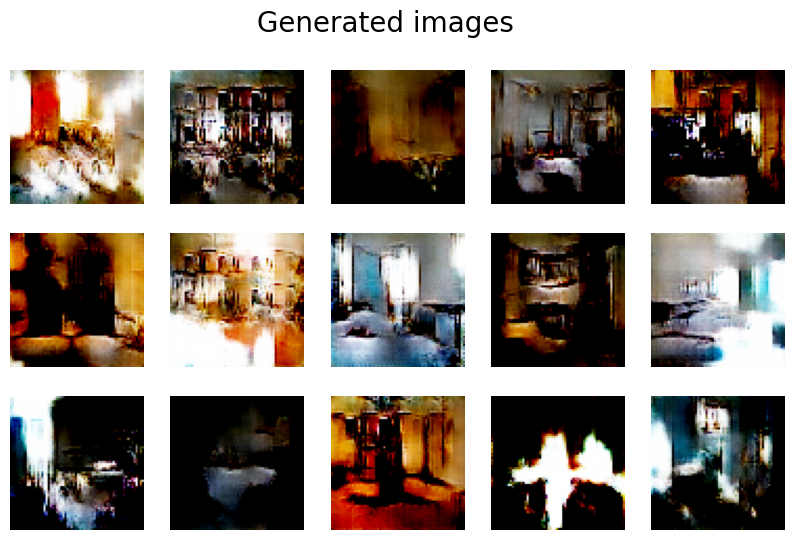

In [ ]:
#Display generated images
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

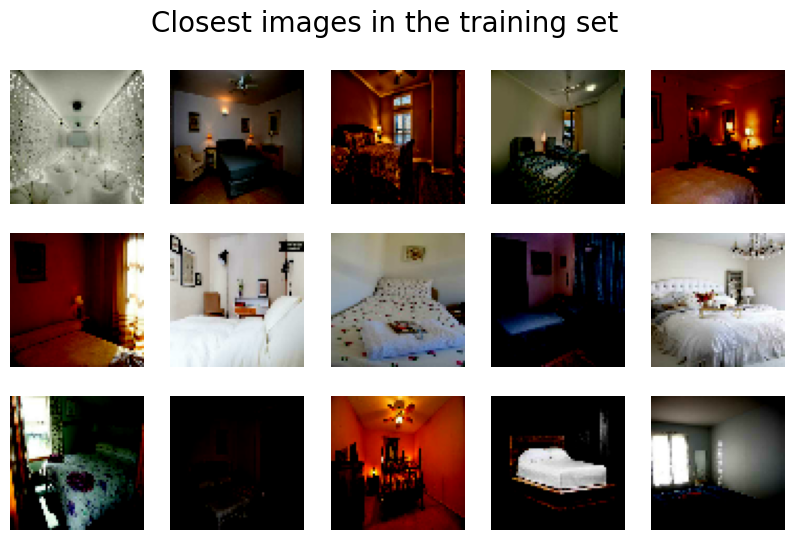

In [ ]:
#Display closest training images
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()


Discussion: The tradeoff between high quality images and diversity is that in order for a model to generator high-quality images, the model needs to learn the features of the training images in order to generate images that resemble them well. By focusing on these features, it makes it hard to generalize and generate good images of diverse bedrooms since the model would only know how to generate one type of bedroom really well and only generate that kind while ignoring other kinds of bedrooms this that is all the model would learn how to generate. For my model, I feel like the images that resembled bedrooms were pretty diverse and had different styles from one another To better the performance of the model, one step would be to use a bigger set of images or even the whole dataset since having more training images would lead to better generated images. Increasing the epochs would also better the performance of the model. Decreasing the batch size further could also help the model but there is only so low it can go since my final model had a batch size of 32. All of these improvement would increase the training time of the model. A practical application for a GAN is to use images of something a person wants to make or design and then have the GAN use training images to generate brand new ones that resemble the training ones but are also different. Another application is to quickly generate different images of a given item that are similar to the training images, as a model would be able to generate them faster than someone could create or take their own images.